# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Importing-Data" data-toc-modified-id="Importing-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importing Data</a></div><div class="lev1 toc-item"><a href="#Time-Series-GP-for-Single-Station" data-toc-modified-id="Time-Series-GP-for-Single-Station-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Time Series GP for Single Station</a></div><div class="lev2 toc-item"><a href="#Model-specification" data-toc-modified-id="Model-specification-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Model specification</a></div><div class="lev2 toc-item"><a href="#Running-STAN-model" data-toc-modified-id="Running-STAN-model-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Running STAN model</a></div><div class="lev2 toc-item"><a href="#Results-and-observations" data-toc-modified-id="Results-and-observations-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Results and observations</a></div><div class="lev1 toc-item"><a href="#Spatiotemporal-model-for-2-stations" data-toc-modified-id="Spatiotemporal-model-for-2-stations-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Spatiotemporal model for 2 stations</a></div><div class="lev2 toc-item"><a href="#Model-Specification" data-toc-modified-id="Model-Specification-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Model Specification</a></div><div class="lev2 toc-item"><a href="#Data-prep" data-toc-modified-id="Data-prep-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Data prep</a></div><div class="lev2 toc-item"><a href="#Running-STAN-model" data-toc-modified-id="Running-STAN-model-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Running STAN model</a></div><div class="lev2 toc-item"><a href="#Results-and-observations" data-toc-modified-id="Results-and-observations-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Results and observations</a></div><div class="lev1 toc-item"><a href="#Imputation-model" data-toc-modified-id="Imputation-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Imputation model</a></div><div class="lev2 toc-item"><a href="#Extracting-daily-$T_n$-and-$T_x$" data-toc-modified-id="Extracting-daily-$T_n$-and-$T_x$-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Extracting daily <span class="MathJax_Preview">T_n</span><script type="math/tex">T_n</script> and <span class="MathJax_Preview">T_x</span><script type="math/tex">T_x</script></a></div><div class="lev2 toc-item"><a href="#Running-Stan-model" data-toc-modified-id="Running-Stan-model-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Running Stan model</a></div><div class="lev2 toc-item"><a href="#Results-and-observations" data-toc-modified-id="Results-and-observations-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Results and observations</a></div><div class="lev1 toc-item"><a href="#Model-shortcomings" data-toc-modified-id="Model-shortcomings-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model shortcomings</a></div>

$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\var}{var}
    \DeclareMathOperator{\cov}{cov}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \DeclareMathOperator{\GP}{\mathcal{GP}}
    \DeclareMathOperator{\l}{\mathscr{l}}
$$

In this notebook I will attempt a small-scale version of imputation using Gaussian Processes.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# module import
import pystan
import numpy as np
import pandas as pd
import matplotlib
import math
import datetime
import matplotlib.pyplot as plt
plt.rc("figure", autolayout=True)
from mpl_toolkits.basemap import Basemap
plt.rcParams['figure.figsize'] = (8.0, 6.0)

# Importing Data

In [2]:
isdList=pd.read_csv("isdList.csv")
isdList.head()

,USAF,WBAN,NAME,CTRY,STATE,ICAO,LAT,LON,ELEV,BEGIN,END
0,10010,99999,JAN MAYEN(NOR-NAVY),NO,NaN,ENJA,70.933,-8.667,9.0,1931,2015
1,10060,99999,EDGEOYA,NO,NaN,NaN,78.250,22.817,14.0,1973,2015
2,10070,99999,NY-ALESUND,SV,NaN,NaN,78.917,11.933,7.7,1973,2015
3,10080,99999,LONGYEAR,SV,NaN,ENSB,78.246,15.466,26.8,1975,2015
4,10090,99999,KARL XII OYA,SV,NaN,NaN,80.650,25.000,5.0,1955,2015


/Users/imolk/bin/venv_python3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


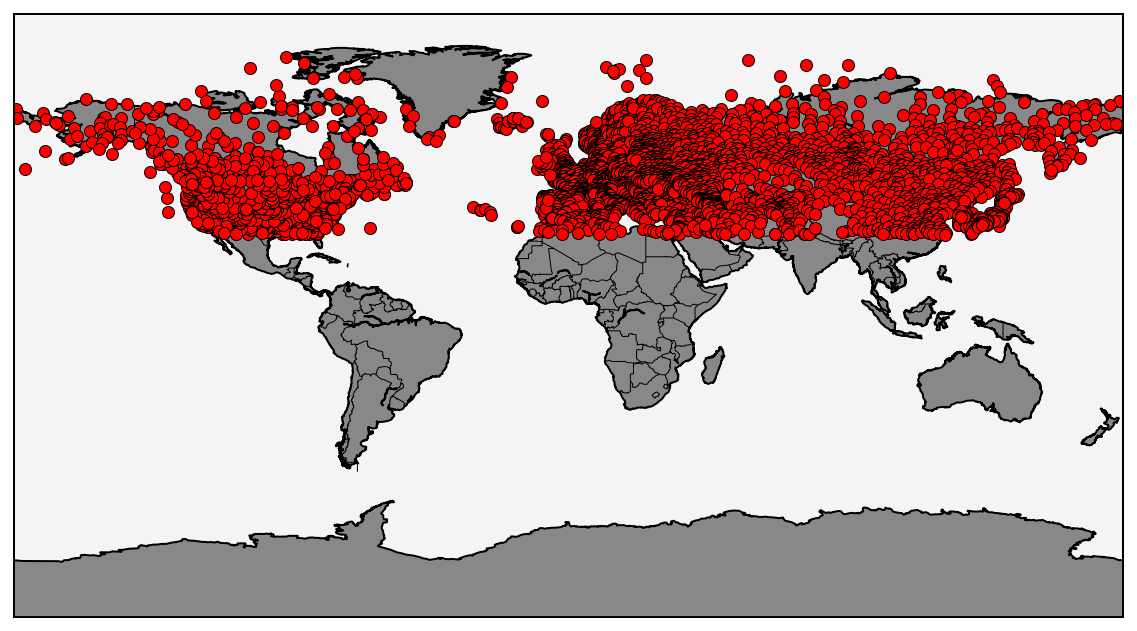

In [3]:
mapplot = Basemap(projection='gall', 
              # with low resolution,
              resolution = 'l', 
              # And threshold 100000
              area_thresh = 100000.0,
              # Centered at 0,0 (i.e null island)
              lat_0=0, lon_0=0)
# Draw the coastlines on the map
mapplot.drawcoastlines()

# Draw country borders on the map
mapplot.drawcountries()

# Fill the land with grey
mapplot.fillcontinents(color = '#888888')

# Draw the map boundaries
mapplot.drawmapboundary(fill_color='#f4f4f4')

# Define our longitude and latitude points
# We have to use .values because of a wierd bug when passing pandas data
# to basemap.
x,y = mapplot(isdList['LON'].values, isdList['LAT'].values)

# Plot them using round markers of size 6
mapplot.plot(x, y, 'ro', markersize=6)

# Show the map
plt.show()              

In [9]:
isdSubset=isdList[isdList["USAF"].isin((725450,725460,725480,725485))]
isdSubset

,USAF,WBAN,NAME,CTRY,STATE,ICAO,LAT,LON,ELEV,BEGIN,END
4062,725450,14990,THE EASTERN IOWA AIRPORT,US,IA,KCID,41.883,-91.717,264.6,1973,2015
4063,725460,14933,DES MOINES INTERNATIONAL AIRPORT,US,IA,KDSM,41.534,-93.653,291.7,1973,2015
4066,725480,94910,WATERLOO MUNICIPAL AIRPORT,US,IA,KALO,42.554,-92.401,264.6,1960,2015
4067,725485,14940,MASON CITY MUNICIPAL ARPT,US,IA,KMCW,43.154,-93.327,373.4,1973,2015


In [10]:
station_filenames = ["%d.%d.processed.2015.2015.csv" % (r["USAF"],r["WBAN"]) for i,r in isdSubset.iterrows()]
def add_dates(df):
    df_dates = [datetime.datetime(*map(int, r[1][["year","month","day","hour","min","seconds"]])) for r in df.iterrows()]
#     df["datetime"] = df_dates
    temp_series = pd.Series(df["temp"].values, index=pd.DatetimeIndex(df_dates))
#     df.set_index(keys=["datetime"], inplace=True)
#     return df["temp"]
    return temp_series
    
hourly_ls = [pd.read_csv("data2015/"+fn, names=["year", "month", "day", "hour", "min", "seconds","temp"]) 
    for fn in station_filenames]
hourly_ls = list(map(add_dates, hourly_ls))

''

/Users/imolk/bin/venv_python3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


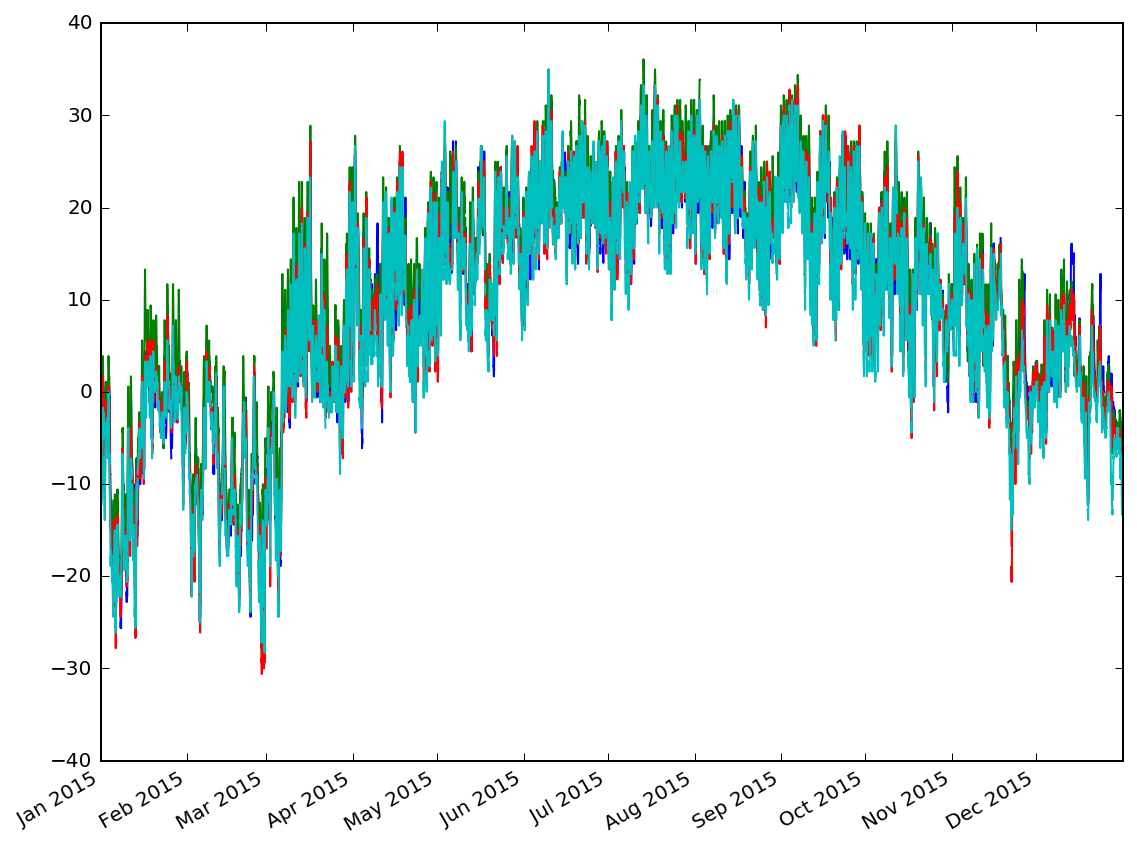

In [11]:
for hourly in hourly_ls:
    plt.plot(hourly)
plt.gcf().autofmt_xdate()
;

''

/Users/imolk/bin/venv_python3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


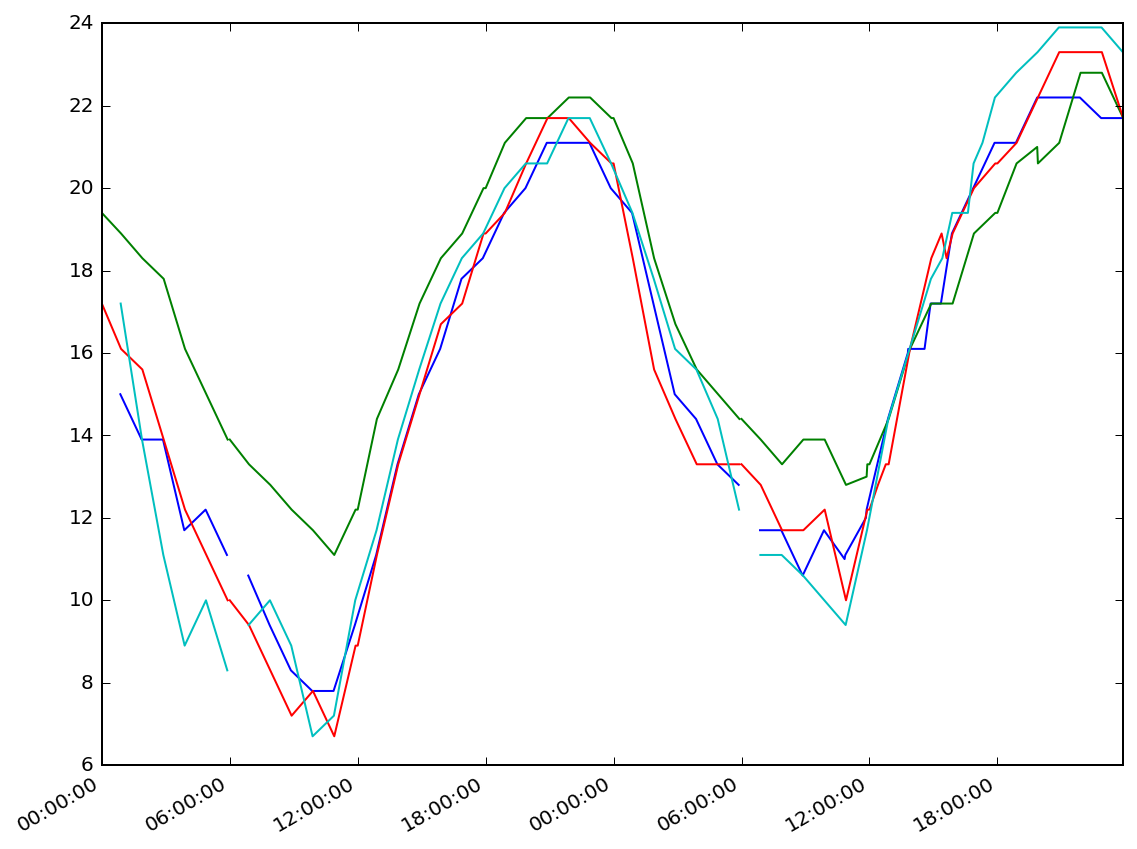

In [12]:
for hourly in hourly_ls:
    plt.plot(hourly["20150601":"20150602"])
plt.gcf().autofmt_xdate()
;

# Time Series GP for Single Station

## Model specification

Start by modelling a single station's data over two days. The model is as follows:

\begin{align}
    T_i &= f(t_i) + \epsilon_i \\
    \epsilon_i &\sim \normal\del{0,\sigma_y^2} \\
    f(t_i) &\sim \GP\del{0, k(t,t')} \\
    k(t,t') &= \sigma_f^2 \exp\del{-\frac{\del{t-t'}^2}{\l_t^2}} \\
\end{align}

## Running STAN model

In [13]:
ns_per_day = 1e9 * 3600 * 24
twodays = hourly["20150601":"20150602"].dropna()
ts_data = {"time": twodays.index.values.astype(float) / ns_per_day,
         "temp": twodays - twodays.mean(),
         "N": twodays.size,
         }

In [16]:
timeseries_model = """
    data {
      int<lower=1> N;
      vector[N] time;
      vector[N] temp;
    }

    parameters {
      real<lower=0> sigmaf2;
      real<lower=0> l_t;
      real<lower=0> sigmay2;

      vector[N] w_s;
    }

    model {
      matrix[N,N] Sigma;
      vector[N] mu_w;
      
      for(i in 1:(N)){
          mu_w[i] <- 0.0;
      }

      // off-diagonal elements
      for(i in 1:(N-1)){
        for(j in (i+1):N){
          Sigma[i,j] <- sigmaf2 * exp( -pow(time[i] - time[j],2)/pow(l_t,2));
          Sigma[j,i] <- Sigma[i,j];
        }
      }

      // diagonal elements
      for(i in 1:N){
        Sigma[i,i] <- sigmaf2 + 0.001;
      }
      l_t ~ normal(0,1);
      sigmaf2 ~ normal(0,10);
      sigmay2 ~ normal(0,1);

      w_s ~ multi_normal(mu_w, Sigma);  
      temp ~ normal(w_s, sigmay2);
    }
"""

In [17]:
ts_fit = pystan.stan(model_code=timeseries_model, data=ts_data,
 iter=1000, chains=4)

## Results and observations

/Users/imolk/bin/venv_python3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


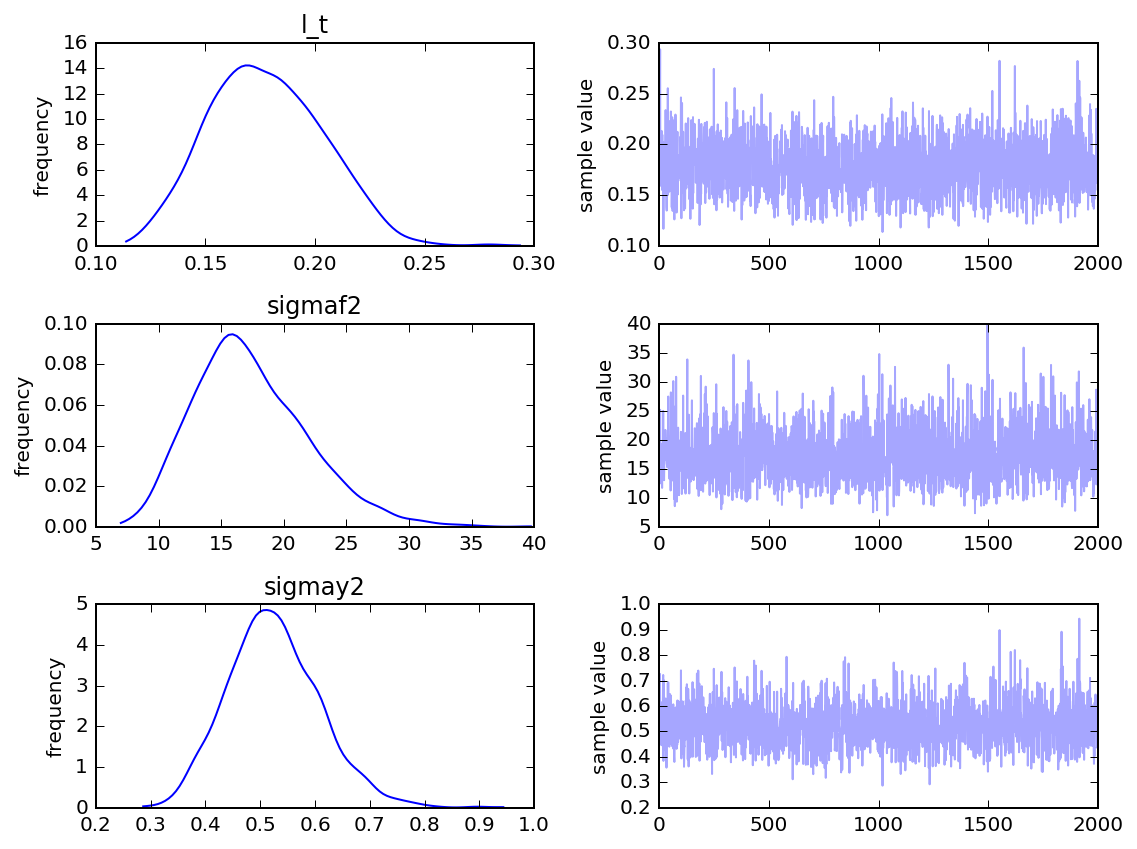

In [18]:
ts_fit.plot(["l_t","sigmaf2","sigmay2"]);

/Users/imolk/bin/venv_python3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


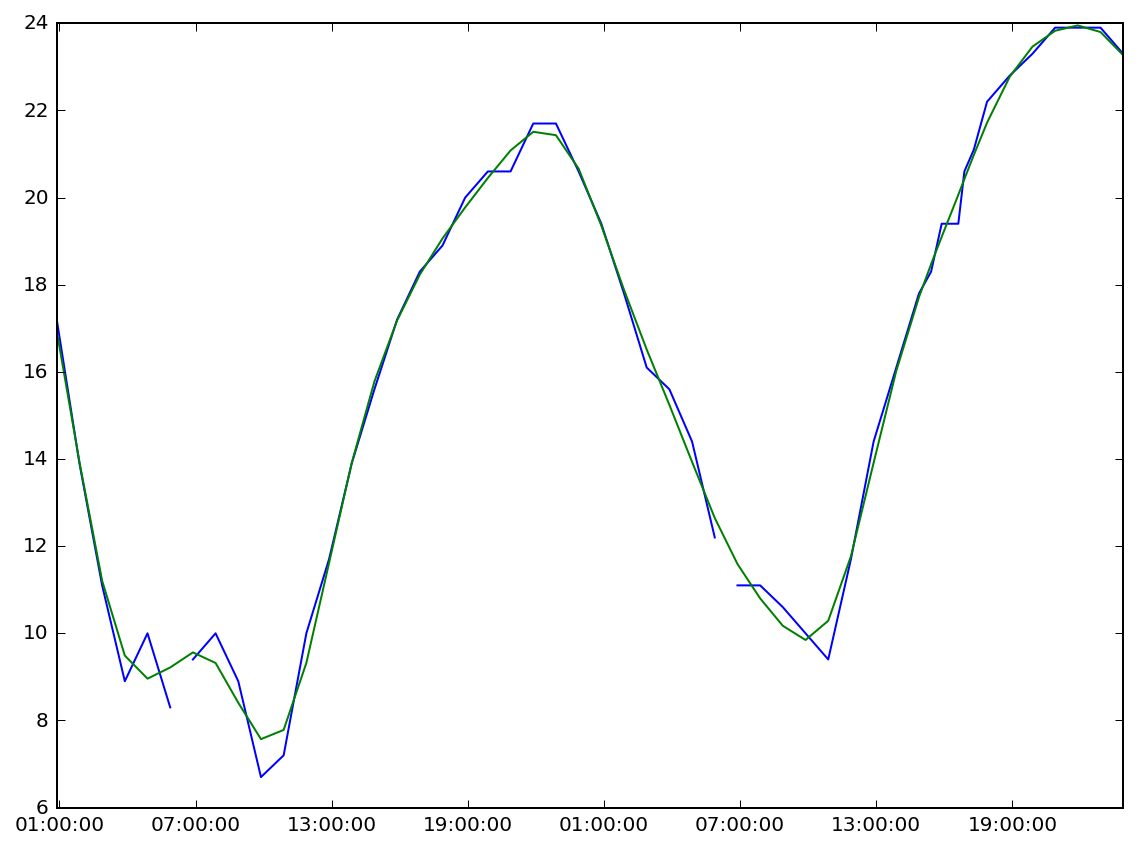

In [19]:
fitted_GP = pd.Series(np.mean(ts_fit.extract("w_s")["w_s"], axis=0), index=twodays.index)
plt.plot(hourly["20150601":"20150602"])
plt.plot(fitted_GP+twodays.mean())

This is a good start. We get nice smooth interpolations between points. The fitted variance of the iid noise is low, which makes sense. It corresponds to the instantaneous noise of the thermometer. We would expect most of the noise to be smooth. The only concern is that the fitted timescale $l_t$ is perhaps a bit low, with the posterior mode at 0.15 (about 4 hours).

# Spatiotemporal model for 2 stations

## Model Specification
Now we'll add a second station, and add a spatial component to the squared exponential kernel of the Gaussian Process. Some notations:
* $x_i$ is the location of the station corresponding to observation $i$
* $t_i$ is the time of observation $i$
* $s_i$ is the station identifier of observation $i$. Therefore we could replace $x_i$ with $x_{s_i}$ to make it explicit that the location is determined by the station of the observation.
* $\mu_s$ is a parameter for the average temperature at station $s$.

\begin{align}
    T_i &= \mu_{s_i} + f(x_i,t_i) + \epsilon_i \\
    \epsilon_i &\sim \normal\del{0,\sigma_y^2} \\
    f(x_i, t_i) &\sim \GP\del{0, k(x,x',t,t')} \\
    k(\vec{x},\vec{x}',t,t') &= \sigma_f^2 \exp\del{-\frac{\del{t-t'}^2}{\l_t^2}-\frac{\del{\vec{x}-\vec{x}'}^2}{\l_x^2}} \\
    \mu_s &\sim \normal\del{0,100} \text{ (fairly non-informative prior)} \\
\end{align}

## Data prep

In [20]:
# http://www.johndcook.com/blog/python_longitude_latitude/
def distance_on_unit_sphere(lat1, long1, lat2, long2):
 
    # Convert latitude and longitude to 
    # spherical coordinates in radians.
    degrees_to_radians = math.pi/180.0
         
    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians
         
    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians
         
    # Compute spherical distance from spherical coordinates.
         
    # For two locations in spherical coordinates 
    # (1, theta, phi) and (1, theta', phi')
    # cosine( arc length ) = 
    #    sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length
     
    cos = (math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2) +
           math.cos(phi1)*math.cos(phi2))
    arc = math.acos( cos )
 
    # Remember to multiply arc by the radius of the earth 
    # in your favorite set of units to get length.
    return arc

In [21]:
isdSubset

,USAF,WBAN,NAME,CTRY,STATE,ICAO,LAT,LON,ELEV,BEGIN,END
4062,725450,14990,THE EASTERN IOWA AIRPORT,US,IA,KCID,41.883,-91.717,264.6,1973,2015
4063,725460,14933,DES MOINES INTERNATIONAL AIRPORT,US,IA,KDSM,41.534,-93.653,291.7,1973,2015
4066,725480,94910,WATERLOO MUNICIPAL AIRPORT,US,IA,KALO,42.554,-92.401,264.6,1960,2015
4067,725485,14940,MASON CITY MUNICIPAL ARPT,US,IA,KMCW,43.154,-93.327,373.4,1973,2015


In [22]:
numstations = len(isdSubset)
pairwiseD = np.zeros((numstations, numstations))
for i in range(numstations):
    for j in range(i+1,numstations):
        station1 = isdSubset.iloc[i]
        station2 = isdSubset.iloc[j]
        lat1 = station1["LAT"]
        long1 = station1["LON"]
        lat2 = station2["LAT"]
        long2 = station2["LON"]
        pairwiseD[i,j] = distance_on_unit_sphere(lat1, long1, lat2, long2)
        pairwiseD[j,i] = pairwiseD[i,j]
pairwiseD

array([[ 0.        ,  0.02594962,  0.01467358,  0.03034751],
       [ 0.02594962,  0.        ,  0.02408798,  0.0285853 ],
       [ 0.01467358,  0.02408798,  0.        ,  0.01581238],
       [ 0.03034751,  0.0285853 ,  0.01581238,  0.        ]])

In [31]:
hourly_df_ls = []
for istation,stationdata in enumerate(hourly_ls):
    hourly_df_ls.append(pd.DataFrame({
        "station":istation+1, # Stan is 1-indexed
        "temp": stationdata.values}, index=stationdata.index))

hourly_df = pd.concat(hourly_df_ls)
twodays_stmp = hourly_df["20150601":"20150602"].dropna()
stmp_data = {
    "N": len(twodays_stmp),
    "numstations": numstations,
    "time": twodays_stmp.index.values.astype(float) / ns_per_day,
    "temp": twodays_stmp["temp"] - twodays_stmp["temp"].mean(),
    "station": twodays_stmp["station"].values,
    "pairwiseD": pairwiseD,
    "l2_t": np.mean(ts_fit.extract("l_t")["l_t"])**2,
}

## Running STAN model

To save ourselves some trouble, we fix $\l_t$ to be the posterior mode from part 1: 0.18.

In [34]:
spatiotemporal_model = """
    data {
      int<lower=1> N;
      int<lower=1> numstations;
      vector[N] time;
      int<lower=1,upper=numstations> station[N];
      matrix[numstations,numstations] pairwiseD;
      vector[N] temp;
      real<lower=0> l2_t;
    }

    parameters {
      real<lower=0> sigmaf;
      real<lower=0> l_x;
      real<lower=0> sigmay;
      real mu_station[numstations];

      vector[N] w_s;
    }
    transformed parameters {
      vector[N] mu_w;
      for(i in 1:(N)){
          mu_w[i] <- mu_station[station[i]];
      }
      mu_w <- mu_w + sigmaf*w_s;
    }

    model {
      matrix[N,N] SigmaGP;
      vector[N] mu_zero; 
      for(i in 1:(N)){
          mu_zero[i] <- 0.0;
      }


      // off-diagonal elements
      for(i in 1:(N-1)){
        for(j in (i+1):N){
          real tdiff;
          real xdiff;
          tdiff <- time[i] - time[j];
          xdiff <- pairwiseD[station[i],station[j]];
          SigmaGP[i,j] <- exp( -pow(tdiff,2)/l2_t -pow(xdiff,2)/pow(l_x,2));
          SigmaGP[j,i] <- SigmaGP[i,j];
        }
      }

      // diagonal elements
      for(i in 1:N){
        SigmaGP[i,i] <- 1.01;
      }
      // l_t ~ normal(0,1);
      l_x ~ normal(0,0.1);
      sigmaf ~ normal(0,5);
      sigmay ~ normal(0,1);
      mu_station ~ normal(0,10);

      w_s ~ multi_normal(mu_zero, SigmaGP);  
      temp ~ normal(mu_w, sigmay);
    }
"""

In [35]:
stmp_fit = pystan.stan(model_code=spatiotemporal_model, data=stmp_data,
 iter=1000, chains=4)

/Users/imolk/bin/venv_python3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


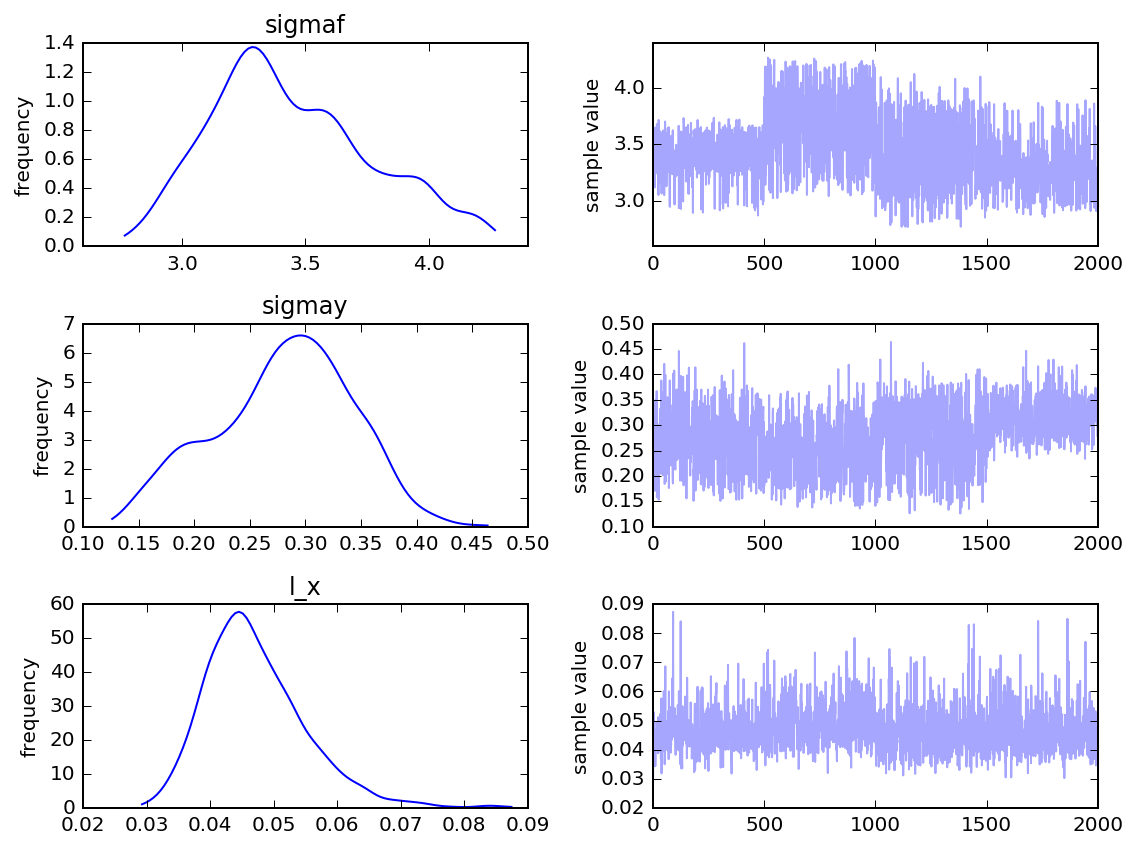

In [36]:
stmp_fit.plot(["sigmaf","sigmay", "l_x"]);

/Users/imolk/bin/venv_python3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


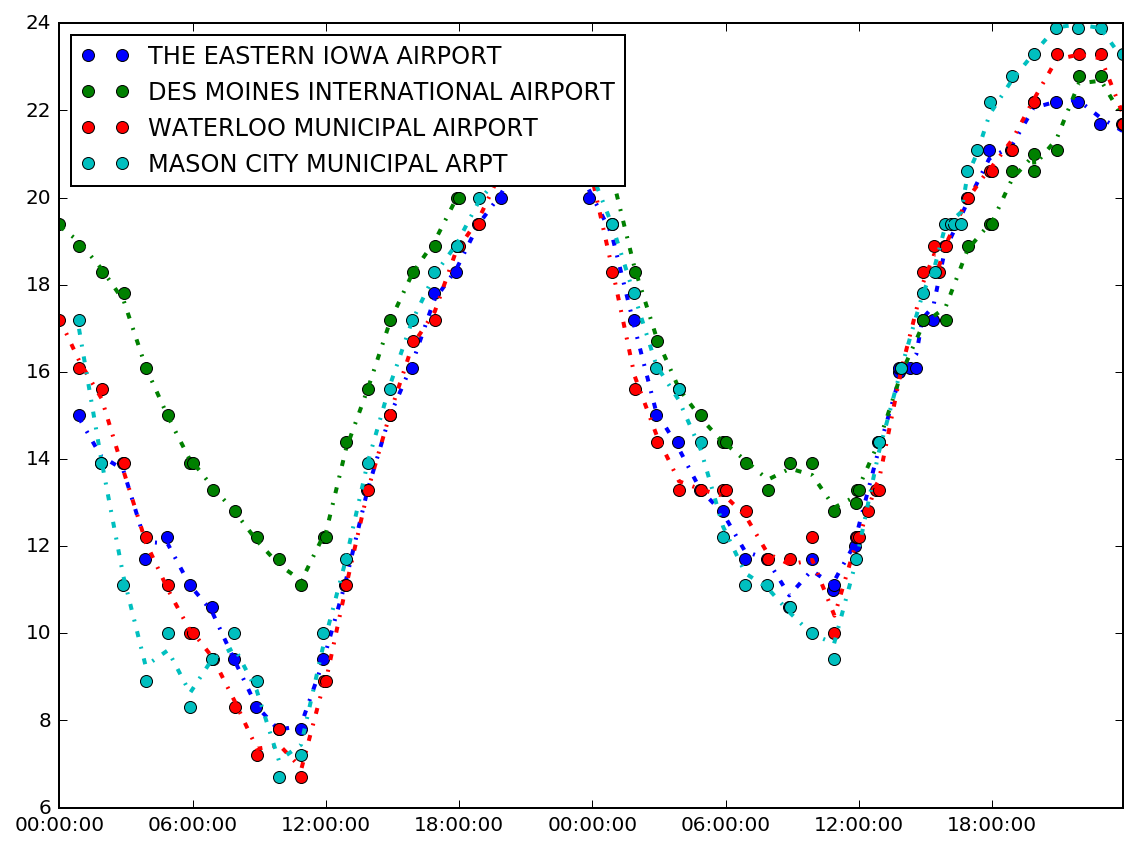

In [37]:
stmp_fitted_GP = pd.Series(np.mean(stmp_fit.extract("mu_w")["mu_w"], axis=0), index=twodays_stmp.index)
for i in range(numstations):
    istat = (twodays_stmp["station"] == i+1).values
    l=plt.plot(twodays_stmp["temp"][istat],"o", label=isdSubset["NAME"].iloc[i])[0]
    plt.plot(stmp_fitted_GP[istat]+twodays_stmp["temp"].mean(), linewidth=2, linestyle="-.", color=l.get_color())
plt.legend(loc="upper left")

## Results and observations

At first glance, this model is doing the right thing, but it is concerning that the posterior for $\l_x$ is centered at a very low value. This essentially means that the measurements at the four stations are independent, which will make our lives difficult when we try to impute data.

# Imputation model

We now get down to business, and replace one of the stations' data with just daily maxima and minima. We will then try to impute the hourly data for that station.

## Extracting daily $T_n$ and $T_x$

In [38]:
time_min = twodays_stmp.index.min()
time_max = twodays_stmp.index.max()
time_impute = pd.date_range(time_min, time_max, freq="H")

In [39]:
first_df = hourly_df_ls[0]["20150601":"20150602"].dropna()
cutpoints = pd.date_range(time_min.replace(hour=17)-pd.DateOffset(days=1), time_max+pd.DateOffset(days=1), freq="D")

In [40]:
first_df["mday"] = pd.cut(first_df.index.values.astype(float), cutpoints.values.astype(float))

In [41]:
first_Tn = first_df.groupby(by="mday").min()
first_Tx = first_df.groupby(by="mday").max()
n_impt_days = len(first_Tn)
day_TxTn = list(range(1, n_impt_days+1))
iday_impute = pd.cut(time_impute.values.astype(float), cutpoints.values.astype(float)).codes
iday_impute

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2], dtype=int8)

## Running Stan model

To make this computationally possible, we replace $\l_t$ and $\l_x$ with their posterior modes from the previous models. This allows us to compute the covariance matrix once, and store its Cholesky decomposition. This makes all future computations much quicker.

In [42]:
imputation_model = """
functions {
    real softmax(vector x, real k){
        real max10x;
        max10x <- max(k*x);
        return (max10x+log(sum(exp(k*x - max10x))))/k;
    }
    real softmin(vector x, real k){
        return -softmax(-x, k);
    }
}
data {
    int<lower=1> numstations;
    int<lower=1> Ntotal; // Ntrain + Nimpt
    
    // training points (for which we have hourly data)
    int<lower=1> Ntrain;

    vector[Ntrain] time_train;
    int<lower=1,upper=numstations> station_train[Ntrain];
    matrix[numstations,numstations] pairwiseD;
    vector[Ntrain] temp_train;
    
    // Tn Tx data
    int<lower=1> n_impt_stations;
    int<lower=1> N_TxTn; // n_impt_stations * n_impt_days
    int<lower=1> n_impt_days;
    int<lower=1,upper=n_impt_days> day_TxTn[N_TxTn];
    int<lower=1,upper=numstations> station_TxTn[N_TxTn];
    vector[N_TxTn] Tx;
    vector[N_TxTn] Tn;
    
    // imputation points (for which we have )
    int<lower=1> n_impt_times;   
    int<lower=1> Nimpt; // n_impt_stations * n_impt_times
    vector[Nimpt] time_impt;
    int<lower=1,upper=n_impt_days> day_impute[Nimpt];
    int<lower=1,upper=numstations> station_impt[Nimpt];
    
    int<lower=1> impt_times_p_day[N_TxTn];
    
    // hyperparameters
    real<lower=0> sigmaf;
    real<lower=0> sigmay;
    real<lower=0> l2_t;
    real<lower=0> l2_x;
    // real<lower=0> l2_h;
    real<lower=0> k_softmax;
}
transformed data{
    matrix[Ntotal,Ntotal] SigmaGP;
    vector[Ntotal] mu_zero; 
    matrix[Ntotal,Ntotal] SigCholesky;
    for(i in 1:Ntotal){
        mu_zero[i] <- 0.0;
    }

    // == off-diagonal elements ==
    // training data
    for(i in 1:(Ntrain-1)){
        for(j in (i+1):Ntrain){
            real tdiff;
            real xdiff;
            tdiff <- time_train[i] - time_train[j];
            xdiff <- pairwiseD[station_train[i],station_train[j]];
            SigmaGP[i,j] <- exp( -pow(tdiff,2)/l2_t -pow(xdiff,2)/l2_x);
            SigmaGP[j,i] <- SigmaGP[i,j];
        }
    }
    
    // imputation data
    for(i in 1:(Nimpt-1)){
        for(j in (i+1):Nimpt){
            real tdiff;
            real xdiff;
            tdiff <- time_impt[i] - time_impt[j];
            xdiff <- pairwiseD[station_impt[i],station_impt[j]];
            SigmaGP[i+Ntrain,j+Ntrain] <- exp( -pow(tdiff,2)/l2_t -pow(xdiff,2)/l2_x);
            SigmaGP[j+Ntrain,i+Ntrain] <- SigmaGP[i+Ntrain,j+Ntrain];
        }
    }
    
    // correlation between training and impt
    for(i in 1:Ntrain){
        for(j in 1:Nimpt){
            real tdiff;
            real xdiff;
            tdiff <- time_train[i] - time_impt[j];
            xdiff <- pairwiseD[station_train[i],station_impt[j]];
            SigmaGP[i,j+Ntrain] <- exp( -pow(tdiff,2)/l2_t -pow(xdiff,2)/l2_x);
            SigmaGP[j+Ntrain,i] <- SigmaGP[i,j+Ntrain];
        }
    }
    
    // diagonal elements
    for(i in 1:Ntotal){
        SigmaGP[i,i] <- 1.01;
    }
    
    SigCholesky <- cholesky_decompose(SigmaGP);
}
parameters {
    real mu_station[numstations];
    vector[Ntotal] w_std;
    vector[Nimpt] temp_impt;
    real mu;
}
transformed parameters {
    vector[Ntotal] mu_w;
    real Tsoftmax[N_TxTn];
    real Tsoftmin[N_TxTn];
    {
        vector[Ntotal] mu_stn;
        for(i in 1:Ntrain){
            mu_stn[i] <- mu_station[station_train[i]];
        }
        for (i in 1:Nimpt){
            mu_stn[i+Ntrain] <- mu_station[station_impt[i]];
        }
        mu_w <- mu + mu_stn + sigmaf*(SigCholesky*w_std);
    }   
    {
        int istart;
        istart <- 1;
        for (i in 1:N_TxTn){
            int ntimes;
            ntimes <- impt_times_p_day[i];
            Tsoftmin[i] <- softmin(segment(temp_impt,istart,ntimes), k_softmax);
            Tsoftmax[i] <- softmax(segment(temp_impt,istart,ntimes), k_softmax);
            istart <- istart + ntimes;
        }
    }
}
model {
    mu_station ~ normal(0,10);
    mu ~ normal(0,10);
    w_std ~ normal(0, 1);  
    temp_train ~ normal(mu_w[1:Ntrain], sigmay);
    temp_impt ~ normal(mu_w[Ntrain+1:Ntotal], sigmay);
    Tn ~ normal(Tsoftmin, 0.1);
    Tx ~ normal(Tsoftmax, 0.1);
}
"""

In [43]:
hourly_train = hourly_df[hourly_df["station"]!=1]["20150601":"20150602"].dropna()

In [79]:
np.mean(ts_fit.extract("l_t")["l_t"])

0.17782943123157482

In [78]:
np.mean(stmp_fit.extract("l_x")["l_x"])

0.047141609355463854

In [51]:
Nimpt = len(time_impute)
Ntrain = len(hourly_train)
impt_data = {
    # == VECTOR LENGTHS ==
    "numstations": numstations,
    "Ntrain": Ntrain,
    "n_impt_times": Nimpt,
    "Nimpt": Nimpt,
    "Ntotal": Nimpt+Ntrain,
    "n_impt_days": n_impt_days,
    "n_impt_stations": 1,
    "N_TxTn": n_impt_days,
    "impt_times_p_day": np.bincount(iday_impute), # won't work with more than 1 station
    # == HOURLY DATA ==
    "time_train": hourly_train.index.values.astype(float) / ns_per_day,
    "station_train": hourly_train["station"],
    "pairwiseD": pairwiseD,
    "temp_train": hourly_train["temp"],
    # == Tn/Tx ==
    "day_TxTn": day_TxTn,
    "station_TxTn": [1]*n_impt_days,
    "Tn": first_Tn["temp"].values,
    "Tx": first_Tx["temp"].values,
    # == IMPUTATION ==
    "time_impt": time_impute.values.astype(float) / ns_per_day,
    "day_impute": iday_impute+1,
    "station_impt": [1]*len(time_impute),
    # == HYPERPARAMETERS ==
    "sigmay": 0.5,
    "sigmaf": 2.5,
    "l2_t": np.mean(ts_fit.extract("l_t")["l_t"])**2,
    "l2_x": np.mean(stmp_fit.extract("l_x")["l_x"])**2,
    "k_softmax": 10.0,
}

In [52]:
impt_fit = pystan.stan(model_code=imputation_model, data=impt_data,
 iter=1000, chains=4)

In [53]:
print(impt_fit)

Inference for Stan model: anon_model_6a9fa08f88d6e5724c3aa9b7078bcd0d.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_station[0]   2.72    0.22   4.37  -5.87  -0.32   2.73   5.75  11.05    398    1.0
mu_station[1]   4.34    0.22   4.39  -4.32   1.34    4.4   7.23  12.97    402    1.0
mu_station[2]   2.81    0.22   4.37  -5.88  -0.26   2.86   5.81   11.2    401    1.0
mu_station[3]   3.09    0.22   4.39  -5.52   0.04    3.1   6.11  11.65    404    1.0
w_std[0]        0.78    0.02    0.4  -0.04   0.51   0.78   1.04   1.58    576    1.0
w_std[1]       -0.17    0.02   0.49  -1.12   -0.5  -0.18   0.17   0.82    668    1.0
w_std[2]        -0.5    0.03   0.74  -1.96  -0.98   -0.5  -0.02   0.96    668    1.0
w_std[3]       -0.67    0.03    0.7  -2.05  -1.14  -0.69  -0.22   0.72    668    1.0
w_std[4]       -1.03    0.03   0.74  -2.46  -1.5

In [54]:
impt_fitted_GP = impt_fit.extract("mu_w", inc_warmup=False)["mu_w"]
imputed_GP = impt_fitted_GP[:,Ntrain:]
imputed_GP_sorted = np.sort(imputed_GP, axis=0)
imputed_0100 = pd.Series(imputed_GP_sorted[100,:], index=time_impute)
imputed_1900 = pd.Series(imputed_GP_sorted[-100,:], index=time_impute)
lower_constraint = pd.Series(first_Tn["temp"].values[iday_impute], index=time_impute)
upper_constraint = pd.Series(first_Tx["temp"].values[iday_impute], index=time_impute)

## Results and observations

''

/Users/imolk/bin/venv_python3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


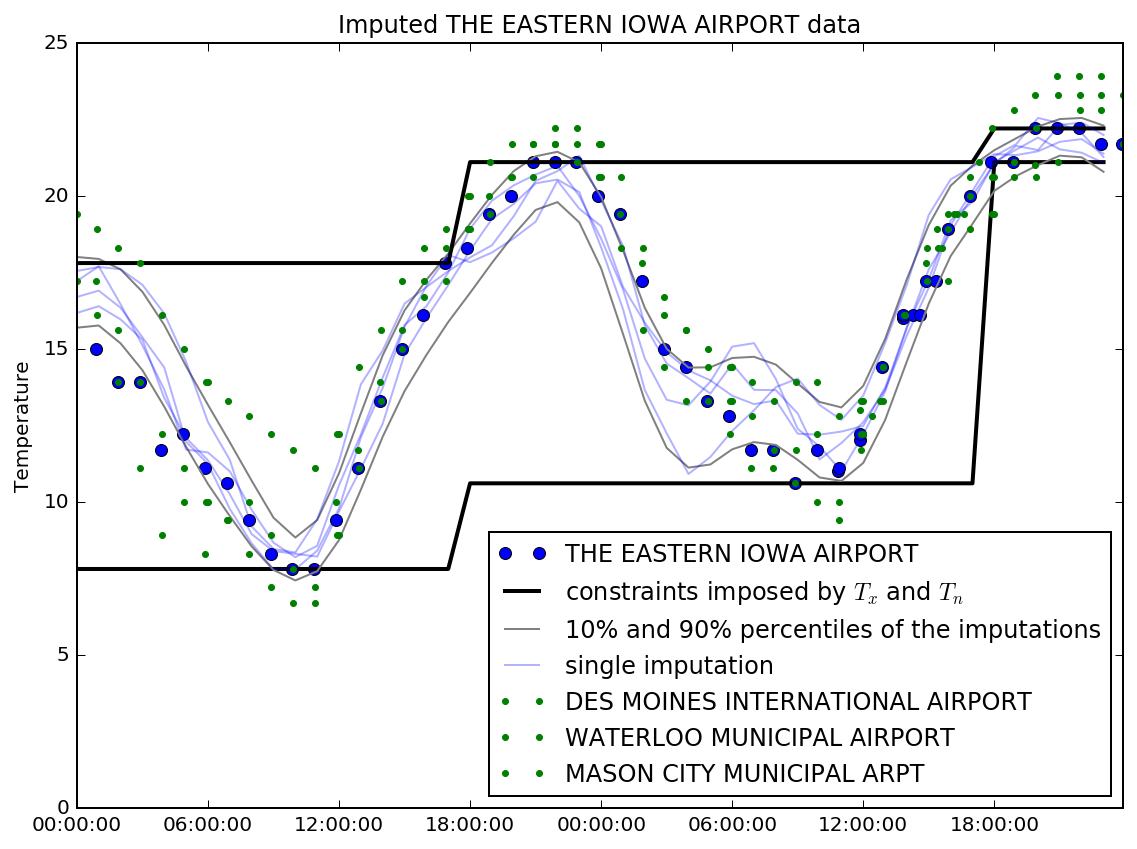

In [76]:
    plt.plot(first_df["temp"], "o", label=isdSubset["NAME"].iloc[0])[0]
    plt.plot(lower_constraint, color="black", label="constraints imposed by $T_x$ and $T_n$", linewidth=2)
    plt.plot(imputed_0100, color="grey", label="10% and 90% percentiles of the imputations")
    plt.plot(imputed_1900, color="grey")
    plt.plot(upper_constraint, color="black", linewidth=2)
    plt.plot(pd.Series(imputed_GP[0,:], index=time_impute), alpha=0.3, color="blue", label="single imputation")
    for i in (100,200,300):
        plt.plot(pd.Series(imputed_GP[i,:], index=time_impute), color="blue", alpha=0.3)
    plt.title("Imputed %s data" % isdSubset["NAME"].iloc[0])
    for i in range(1,numstations):
        istat = (twodays_stmp["station"] == i+1).values
        l=plt.plot(twodays_stmp["temp"][istat], 
                    color="green", linestyle="none", marker=".", 
                    label=isdSubset["NAME"].iloc[i])[0]
    plt.ylabel("Temperature")
    plt.legend(loc="best")
    plt.ylim(0,25)
    ;

This is working impressively well already! The imputations actually track the data, and respect the daily minima and maxima, within some error margin allowed by the softmax function, and by the measurement error term. This approximation can be tightened at the expense of higher computational time. 

The model automatically picked out that $T_x$ on the first day could have been set by the 00:00:00 measurement, or by the 17:00:00 measurement. The imputations aren't pulled up by the station that has higher temperatures in the late morning of the first day, because the model knows than a $T_n$ of 8° needs to be reached before 5 pm. Interestingly, on the second day, there is much more uncertainty as to the time of the daily minimum than the time of the maximum.

Perhaps the only negative is that the model overestimates the temperature at the very start of the window. Because all other stations record a higher temperature, the model is happy to allow the imputations to drift up. Encouragingly, the error bars are wide, as the model acknowledges that the daily max could also have been reached at 5pm the next day.

# Model shortcomings

There are a few important things that our model doesn't have yet:

1. A periodic, daily component (diurnal cycle)
2. A component of the squared exponential kernel for altitude (either that, or a systematic adjustment)
3. Accounting for imperfections in the hourly measurements. Why are they not as trustworthy? The idea is that we want to use them to inform the *shape* of the hourly temperatures, but we maybe don't want them to overly influence the long-term trends. I've allowed this by giving each station its own $\mu$ parameter, that allows the temperature at each station to be systematically higher or lower than is accounted for by the Gaussian Process model, but perhaps this could be further improved.